C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 109s 4s/step - accuracy: 0.3017 - loss: 2.0510 - val_accuracy: 0.3550 - val_loss: 1.3675
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.3722 - loss: 1.3574 - val_accuracy: 0.3550 - val_loss: 1.3735
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.4000 - loss: 1.3565 - val_accuracy: 0.3550 - val_loss: 1.3684
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.4040 - loss: 1.3468 - val_accuracy: 0.3550 - val_loss: 1.3657
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.3912 - loss: 1.3432 - val_accuracy: 0.3550 - val_loss: 1.3702
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.3755 - loss: 1.3548 - val_accuracy: 0.3550 - val_loss: 1.3715
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.3960 - loss: 1.3379 - val_accuracy: 0.3550 - val_loss: 1.3616
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.4000 - loss: 1.3401 - val_accuracy: 0.3550 - v

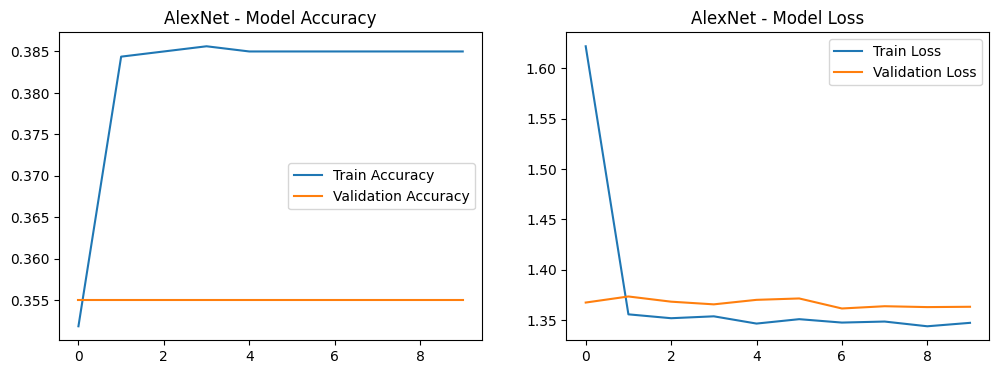

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('piezoelectric_breathing_dataset.csv')
sensor_values = data['Sensor Value'].values
categories = data['Category'].values

# Convert sensor values into images (grayscale to RGB)
X = np.array([np.full((128, 128, 1), value / 2.5) for value in sensor_values])
X = np.repeat(X, 3, axis=-1)  # Convert grayscale to RGB

# Resize images to 227x227 for AlexNet
X_resized = np.array([tf.image.resize(img, (227, 227)).numpy() for img in X])
y = np.array(categories)

# Split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X_resized, y, test_size=0.2, random_state=42)

# Step 2: Define the AlexNet architecture
model = models.Sequential([
    layers.Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=(227, 227, 3)),
    layers.MaxPooling2D((3, 3), strides=2),
    layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
    layers.MaxPooling2D((3, 3), strides=2),
    layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((3, 3), strides=2),
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')  # 5 classes
])

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 3: Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

# Save the trained model
model.save('piezoelectric_breathing_model_alexnet.h5')

# Step 4: Plot accuracy and loss graphs
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('AlexNet - Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('AlexNet - Model Loss')
plt.legend()

plt.show()

# Function for user input prediction
def predict_breathing_pattern():
    sensor_value = float(input("Enter sensor value: "))
    img = np.full((128, 128, 1), sensor_value / 2.5)
    img = np.repeat(img, 3, axis=-1)
    img_resized = tf.image.resize(img, (227, 227)).numpy()
    img_resized = np.expand_dims(img_resized, axis=0)  # Add batch dimension
    prediction = model.predict(img_resized)
    predicted_class = np.argmax(prediction)
    print(f"Predicted Breathing Pattern Category: {predicted_class}")


In [9]:
import tensorflow as tf
import numpy as np
import pandas as pd

# Step 1: Load the trained AlexNet model
model = tf.keras.models.load_model('piezoelectric_breathing_model_alexnet.h5')

# Load dataset and clean column names
df = pd.read_csv("breathing_dataset.csv")
df.columns = df.columns.str.strip()  # Remove any extra spaces from column names

# Debugging: Print available column names
print("Available columns:", df.columns)

# Ensure correct column names
sensor_column = "Sensor Value"  # Adjusted based on dataset
label_column = "Label"  # Adjusted based on dataset

# Check if necessary columns exist
if sensor_column not in df.columns or label_column not in df.columns:
    raise ValueError("Dataset must contain 'Sensor Value' and 'Label' columns!")

# Normalize sensor values properly
sensor_mean = df[sensor_column].mean()
sensor_std = df[sensor_column].std()

def normalize_sensor_value(sensor_value):
    return (sensor_value - sensor_mean) / sensor_std  # Use standardization

# Create label mapping
unique_labels = sorted(df[label_column].unique().tolist())
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}

# Debugging: Print label mapping
print("Label Mapping:", label_mapping)

# Function to predict breathing pattern
def predict_breathing_pattern(sensor_value):
    # Normalize the input sensor value
    sensor_normalized = normalize_sensor_value(sensor_value)

    # Generate a dummy image
    X_input = np.full((128, 128, 1), sensor_normalized)
    X_input_resized = np.repeat(X_input, 3, axis=-1)  # Convert to RGB

    # Resize to match AlexNet input shape (227x227)
    X_input_resized = tf.image.resize(X_input_resized, (227, 227)).numpy()
    X_input_resized = np.expand_dims(X_input_resized, axis=0)  # Add batch dimension

    # Debugging: Print input shape
    print("Input shape:", X_input_resized.shape)

    # Predict the category
    predictions = model.predict(X_input_resized)
    print("Raw predictions:", predictions)  # Debugging

    predicted_class = np.argmax(predictions, axis=-1)[0]

    # Get predicted label correctly
    predicted_label = unique_labels[predicted_class] if predicted_class < len(unique_labels) else "Unknown"

    return predicted_label, predictions

# Input sensor value
sensor_value = float(input("Enter a piezoelectric sensor value: "))
predicted_label, probabilities = predict_breathing_pattern(sensor_value)
print(f"Sensor Value: {sensor_value} -> Predicted: {predicted_label} (Probabilities: {probabilities})")


Available columns: Index(['Timestamp', 'Sensor Value', 'Amplitude', 'Frequency', 'Label'], dtype='object')
Label Mapping: {'Apnea': 0, 'Deep': 1, 'Irregular': 2, 'Normal': 3, 'Shallow': 4}


Enter a piezoelectric sensor value:  459


Input shape: (1, 227, 227, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Raw predictions: [[0. 1. 0. 0. 0.]]
Sensor Value: 459.0 -> Predicted: Deep (Probabilities: [[0. 1. 0. 0. 0.]])


In [10]:
import tensorflow as tf

# Load the trained AlexNet model
model = tf.keras.models.load_model('piezoelectric_breathing_model_alexnet.h5')


In [14]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import numpy as np
import tensorflow as tf

# Load trained AlexNet model
model = tf.keras.models.load_model('piezoelectric_breathing_model_alexnet.h5')

# Generate predictions for the test dataset
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the predicted class indices

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Precision, Recall, and F1 Score
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# Get the unique class labels present in y_test
unique_classes = np.unique(y_test)
target_names = ['Normal', 'Shallow', 'Deep', 'Apnea', 'Irregular'][:len(unique_classes)]

# Print metrics
print("Confusion Matrix:")
print(conf_matrix)

print("\n AlexNet - Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=target_names))

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 443ms/step
Confusion Matrix:
[[  0  86   0   0]
 [  0 142   0   0]
 [  0  81   0   0]
 [  0  91   0   0]]

 AlexNet - Classification Report:
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00        86
     Shallow       0.35      1.00      0.52       142
        Deep       0.00      0.00      0.00        81
       Apnea       0.00      0.00      0.00        91

    accuracy                           0.35       400
   macro avg       0.09      0.25      0.13       400
weighted avg       0.13      0.35      0.19       400

Precision: 0.1260
Recall: 0.3550
F1 Score: 0.1860


C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f